# Dengue Analysis

In [1]:
# Import essentials
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

Carreguem les dades i les ajuntarem totes en un mateix dataframe (aixi podrem omplir NaNs de tot)

In [2]:
# load the csv
train_values_df = pd.read_csv('dengue_features_train.csv') # Load the `train` file
train_labels_df = pd.read_csv('dengue_labels_train.csv') # Load the `train` file
test_values_df = pd.read_csv('dengue_features_test.csv') # Load the `train` file

#store the original dimensions
len_train=train_values_df.shape[0]
len_test=test_values_df.shape[0]

# el train es train_values + train_labels
train= pd.concat([train_values_df, train_labels_df['total_cases']], axis=1, sort=False)

# el df_TOTAL es tot, train (values + labels) y test concatenat
df_TOTAL = pd.concat([train, test_values_df]).reset_index(drop=True)

# posem les dates en format de dates (aixi al fer plots es mes facil)
df_TOTAL['Date_Start_week'] =  pd.to_datetime(df_TOTAL['week_start_date'], format='%Y-%m-%d')

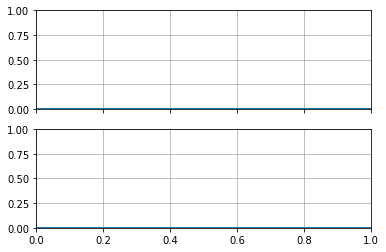

In [4]:
plt.xcorr

<function matplotlib.pyplot.xcorr(x, y, normed=True, detrend=<function detrend_none at 0x000001D9D090AC80>, usevlines=True, maxlags=10, *, data=None, **kwargs)>

Mirem els Nans?

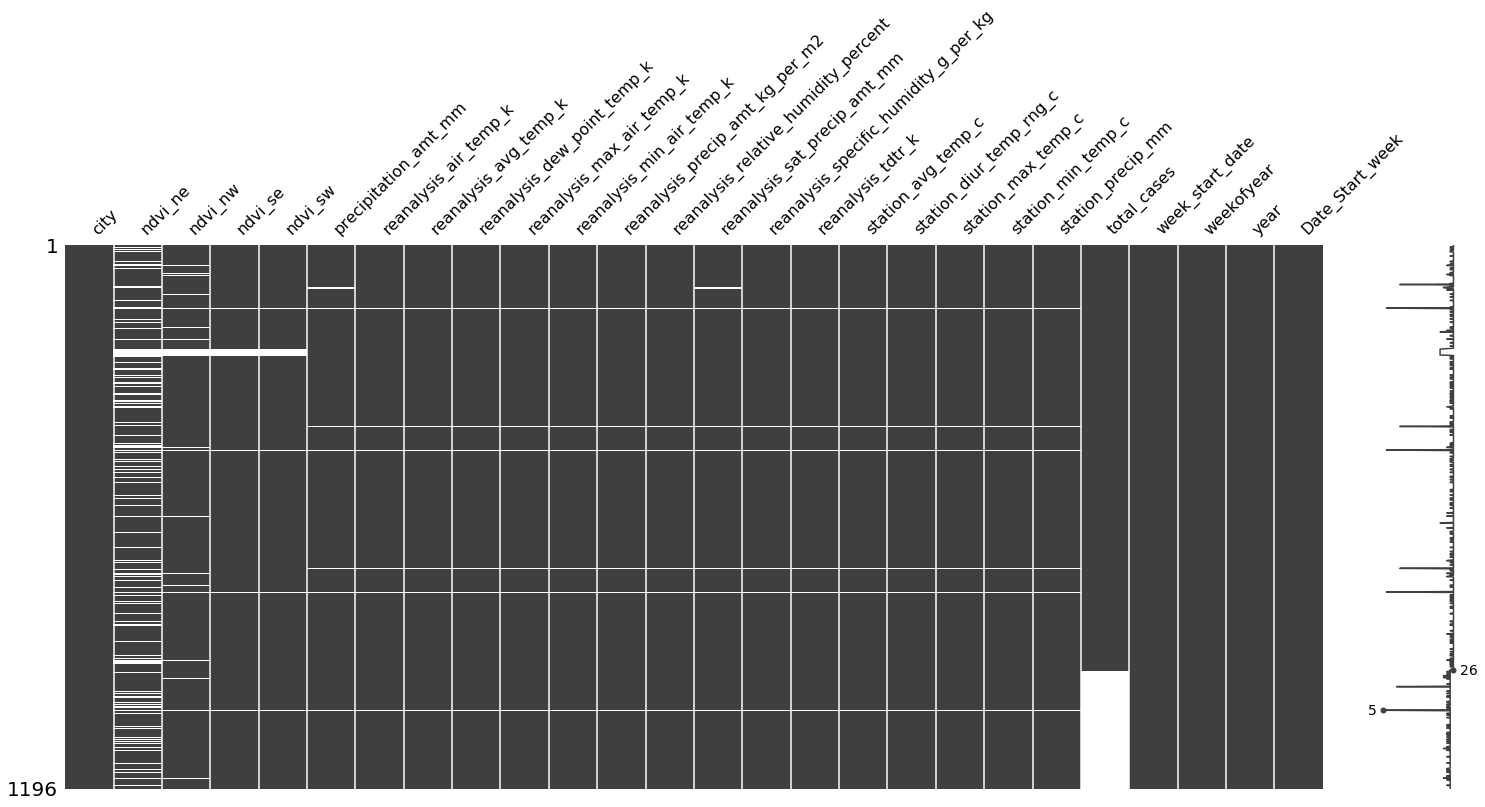

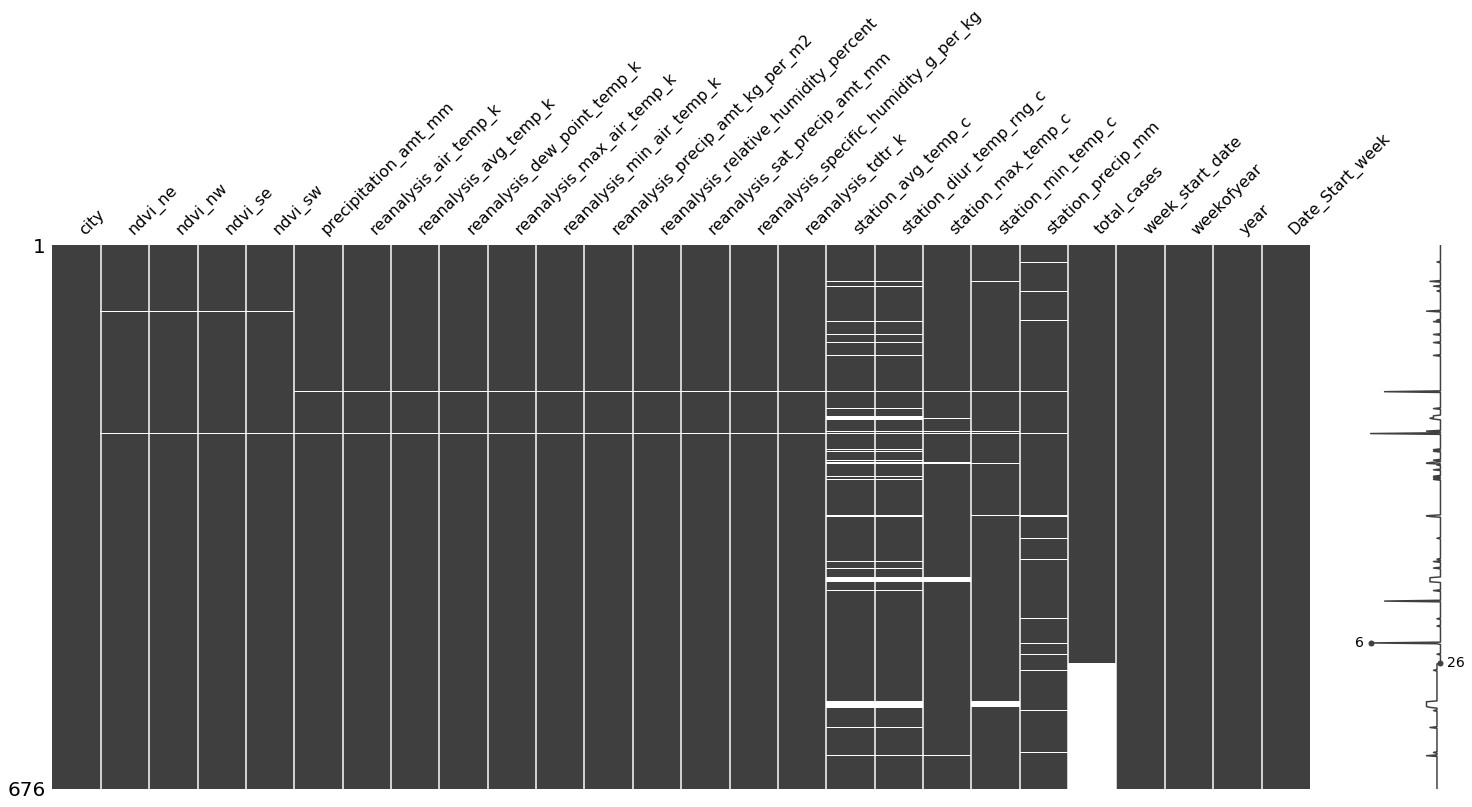

In [5]:
msno.matrix(df_TOTAL[df_TOTAL['city']=='sj'])
plt.show()

msno.matrix(df_TOTAL[df_TOTAL['city']=='iq'])
plt.show()

* En general hi han bastants NaNs (sobretot a ndvi, i en concret ndvi-ne).
* veiem algunes setmanes en que falta tot (coincideixen amb els 10 NaNs del reanalisis)
    * les de train les eliminarem
    * per 'sj' n'hi han dues al test (no les podem eliminar). Aquestes les omplirem amb els valors tipics de la mateixa setmana.

In [6]:
# aqui simplement omplim amb valors duesfiles al test que no tenen ni un sol valor de cap variable
df_kk = df_TOTAL[df_TOTAL['city']=='sj']
id_nans_test = df_kk[pd.isnull(df_kk['reanalysis_air_temp_k'])].index.tolist()

df_TOTAL.loc[id_nans_test]

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,week_start_date,weekofyear,year,Date_Start_week
87,sj,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.0,1992-01-01,1,1992,1992-01-01
139,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.0,1993-01-01,53,1993,1993-01-01
399,sj,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64.0,1998-01-01,1,1998,1998-01-01
451,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1999-01-01,53,1999,1999-01-01
711,sj,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,2004-01-01,1,2004,2004-01-01
763,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,2005-01-01,53,2005,2005-01-01
1491,sj,0.5004,0.161425,0.160786,0.188650,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01,1,2009,2009-01-01
1543,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01,53,2010,2010-01-01


les dues ultimes (setmana 1 i 53) son de test, i omplirem dades amb els promitjos de la mateixa setmana per altres anys

In [7]:
kk1 = df_kk[df_kk['weekofyear']==1].mean(axis=0)
kk53 = df_kk[df_kk['weekofyear']==52].mean(axis=0)

list_to_fill_53 = ['ndvi_ne', 'ndvi_nw','ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']

list_to_fill_1 = ['precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']

for i in list_to_fill_1:
    df_TOTAL[i][id_nans_test[-1]] = kk1[i]
    
for i in list_to_fill_53:
    df_TOTAL[i][1491] = kk53[i]

In [8]:
del [kk1,kk53,list_to_fill_53,list_to_fill_1,df_kk]

Ara eliminem les setmanes que tenen tot NaNs (podriem mirar d'omplir-les amb dades?)

In [9]:
# Aqui ara eliminem del dataframe les setmanes que tenen tot NaNs (son les mateixes que tenen reanalisis NAN), del train eh (al test no les podem aliminar)
id_drop= df_TOTAL[pd.isnull(df_TOTAL['reanalysis_air_temp_k'])].index.tolist()

#eliminem del datframe i dels labels
df_TOTAL = df_TOTAL.drop(id_drop,axis=0)
train_labels_df = train_labels_df.drop(id_drop,axis=0)

#### Passem Temperatures de Kelvin a Celsius? aixi estan totes igual
* segurament no importa, perque despres ho estandaritzem...pero per si de cas

In [10]:
# passem a ºC totes les que estan en K
df_TOTAL['reanalysis_air_temp_c']=df_TOTAL['reanalysis_air_temp_k'] - 273.15
df_TOTAL['reanalysis_max_air_temp_c']=df_TOTAL['reanalysis_max_air_temp_k'] - 273.15
df_TOTAL['reanalysis_min_air_temp_c']=df_TOTAL['reanalysis_min_air_temp_k'] - 273.15
df_TOTAL['reanalysis_dew_point_temp_c']=df_TOTAL['reanalysis_dew_point_temp_k'] - 273.15
df_TOTAL['reanalysis_avg_temp_k']=df_TOTAL['reanalysis_avg_temp_k'] - 273.15

df_TOTAL = df_TOTAL.drop(columns=['reanalysis_air_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k',
                                  'reanalysis_dew_point_temp_k','reanalysis_avg_temp_k'])

In [11]:
df_TOTAL.columns

Index(['city', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'week_start_date', 'weekofyear', 'year', 'Date_Start_week',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c'],
      dtype='object')

In [12]:
#### fem plot de correlacions per veure que tenim
cor=df_TOTAL.corr()
#print ('Training correlations (Pearson): \n', cor["total_cases"].sort_values(ascending=False))

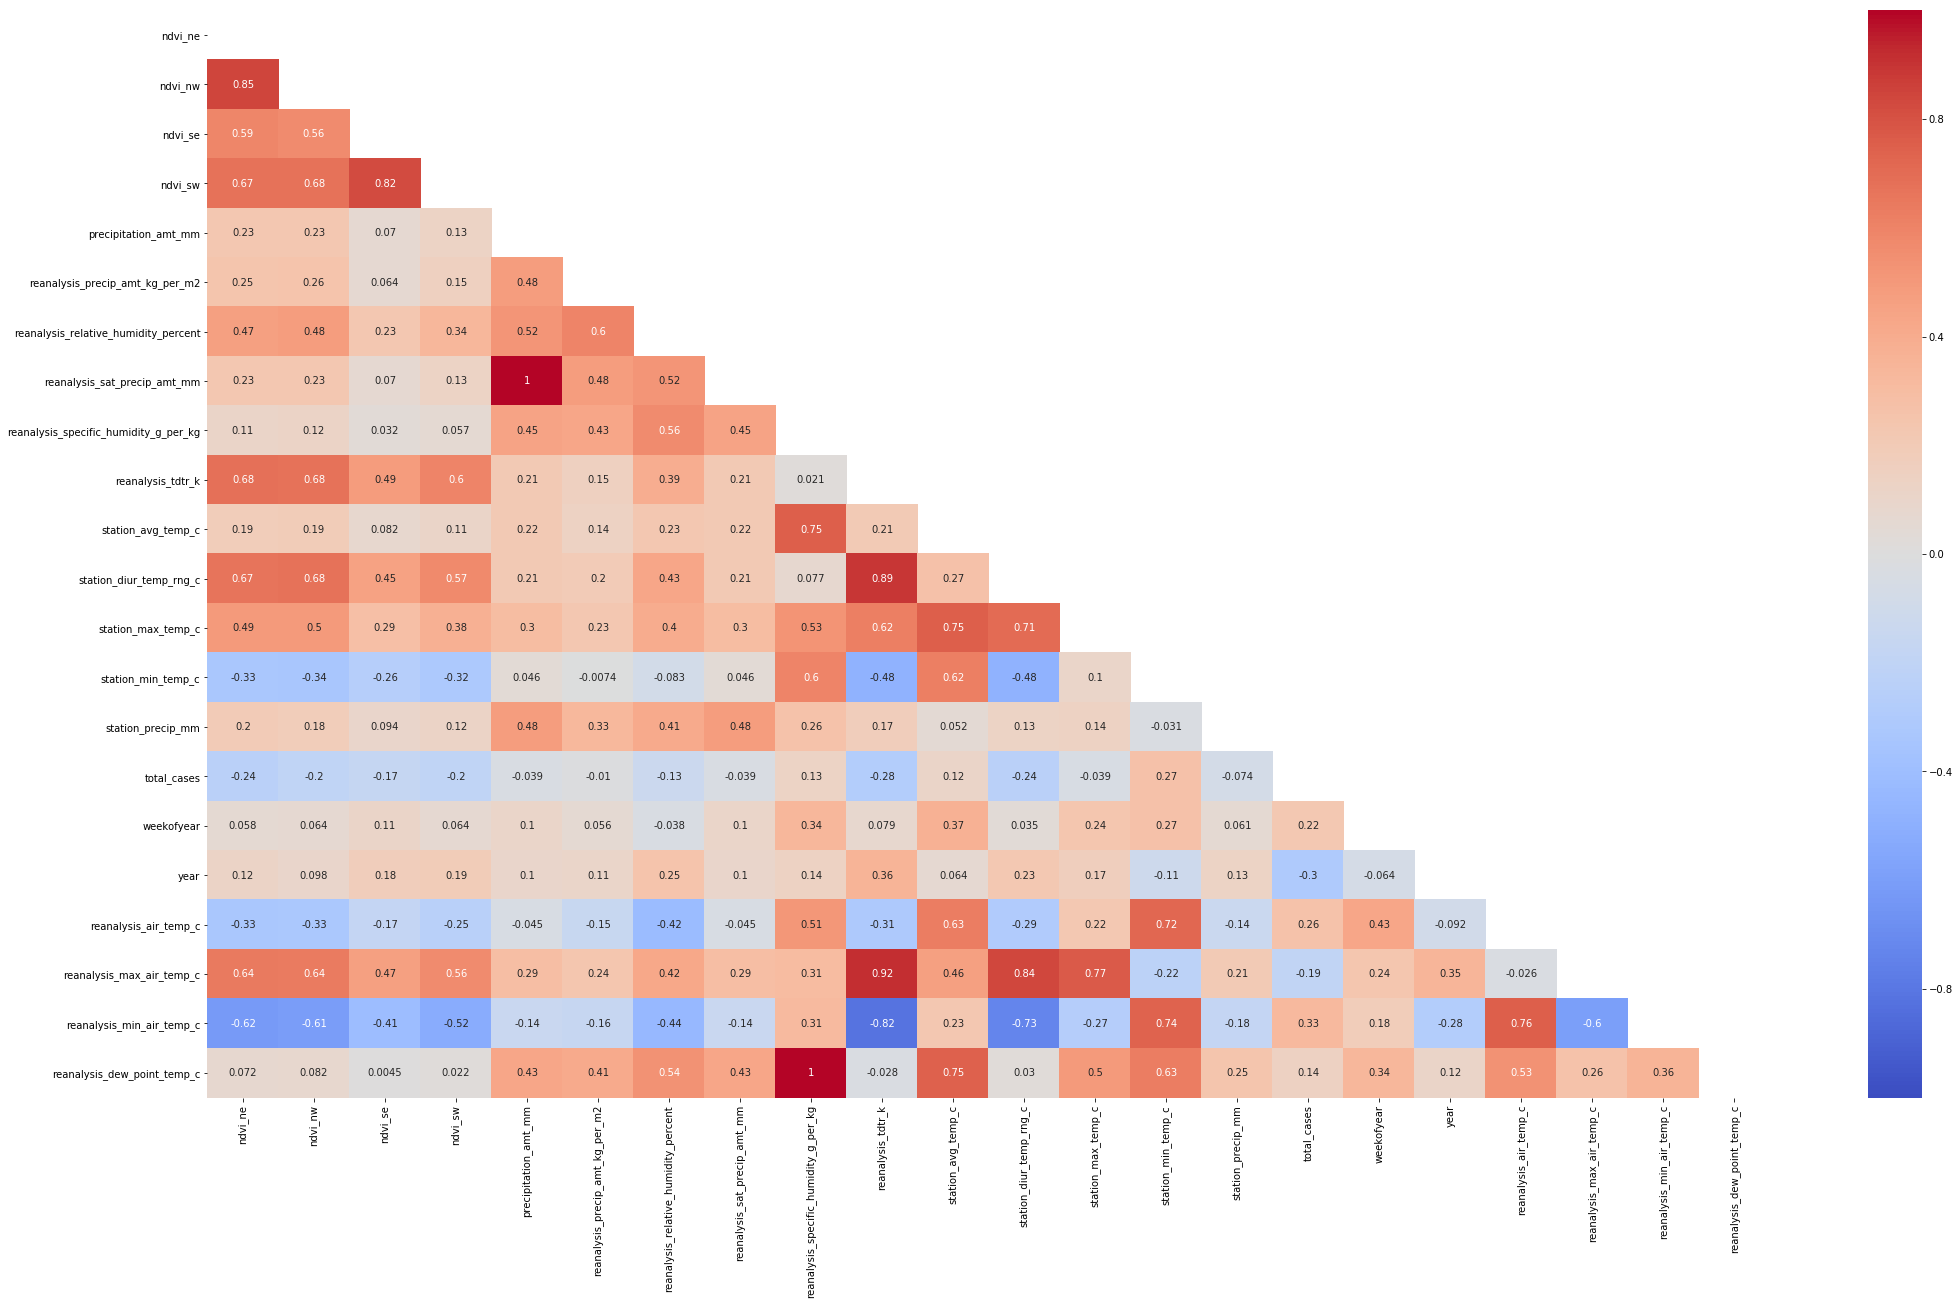

In [13]:
mask = np.zeros_like(df_TOTAL.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(35,20))
sns.heatmap(df_TOTAL.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask = mask);

En aquest grafic veiem com algunes variables tenen correlacions de 1 entre elles, aquestes les podem eliminar ja que venen a ser el mateix:
    * reanalysis_sat_precip_amt_mm i precipitation_amt_mm --> eliminem reanalysis
    * reanalysis_specific_humidity_g_per_kg i reanalysis_dew_point_temp_c --> eliminem dew_point
A part, els NDVI veiem com els nw i ne estan correlacionats (0.85) i sw i sw amb 0.82.
    * Podriem crear una nova que sigui ndvi_n i ndvi_s amb el valor mig dels dos que corresponen, aixi eliminem bastants Nans. 
    * els NaNs que quedin ja veurem com els eliminem

In [14]:
df_TOTAL = df_TOTAL.drop(columns=['reanalysis_sat_precip_amt_mm','reanalysis_sat_precip_amt_mm','week_start_date'])

In [15]:
df_TOTAL['ndvi_N']=df_TOTAL[['ndvi_nw','ndvi_ne']].mean(axis=1)
df_TOTAL['ndvi_S']=df_TOTAL[['ndvi_sw','ndvi_se']].mean(axis=1)

df_TOTAL=df_TOTAL.drop(columns=['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se'])

### omplirem els Nans amb dades
1. en molts casos tenim bastants NaNs seguits, farem servir models de lineal regression entre variables que estan correlacionades per omplir NaNs

### 1) station_avg_temp_c a partir dereanalysis_air_temp_c (0.62 de correlacio lineal)
* te mes correlacio amb altres variables, pero els errors a l'aplicar model son mes alts

Mean Square error: 0.5065357816415449


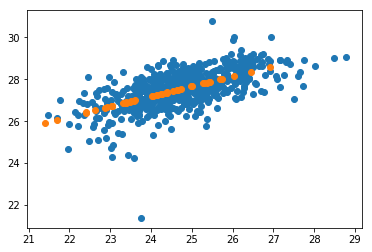

In [16]:
train_iq=df_TOTAL[df_TOTAL['city']=='iq']

id_missing= train_iq[pd.isnull(train_iq['station_avg_temp_c'])].index.tolist()

xx = train_iq['reanalysis_air_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
yy=train_iq['station_avg_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
xx_test=train_iq['reanalysis_air_temp_c'][id_missing].values.reshape(-1,1)


LR=LinearRegression()

results = cross_val_score(LR, xx, yy, cv=6, scoring='neg_mean_squared_error')
print('Mean Square error:',(-results.mean()))

#train model and predict
LR.fit(xx,yy)
pred=LR.predict(xx_test)

#fem un plot
plt.scatter(xx,yy)
plt.scatter(xx_test,pred)
plt.show()

# ho posem on toca
df_TOTAL['station_avg_temp_c'][id_missing] = pred[:,0]

### 2) station_max_temp_c a partir de reanalysis_max_air_temp_c

Mean Square error: 1.154173218978135


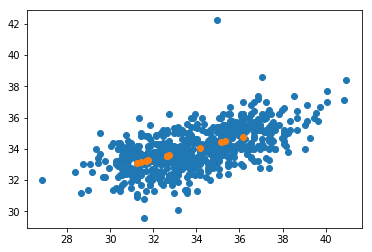

In [17]:
## repetim per maxim
id_missing= train_iq[pd.isnull(train_iq['station_max_temp_c'])].index.tolist()
xx = train_iq['reanalysis_max_air_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
yy=train_iq['station_max_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
xx_test=train_iq['reanalysis_max_air_temp_c'][id_missing].values.reshape(-1,1)

results = cross_val_score(LR, xx, yy, cv=6, scoring='neg_mean_squared_error')
print('Mean Square error:',(-results.mean()))

#predict
LR.fit(xx,yy)
pred=LR.predict(xx_test)

#plot
plt.scatter(xx,yy)
plt.scatter(xx_test,pred)
plt.show()

# ho posem on toca i fem un plot de la time series per veure com queda
df_TOTAL['station_max_temp_c'][id_missing] = pred[:,0]

### 2) station_min_temp_c a partir de reanalysis_min_air_temp_c

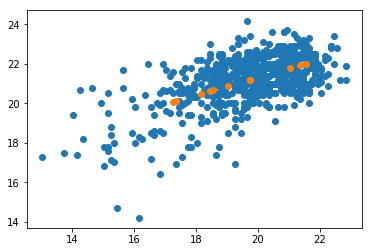

In [18]:
## repetim per minim
id_missing= train_iq[pd.isnull(train_iq['station_min_temp_c'])].index.tolist()
xx = train_iq['reanalysis_min_air_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
yy=train_iq['station_min_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
xx_test=train_iq['reanalysis_min_air_temp_c'][id_missing].values.reshape(-1,1)

#predict
LR.fit(xx,yy)
pred=LR.predict(xx_test)

#plot
plt.scatter(xx,yy)
plt.scatter(xx_test,pred)
plt.show()

# ho posem on toca i fem un plot de la time series per veure com queda
df_TOTAL['station_min_temp_c'][id_missing] = pred[:,0]

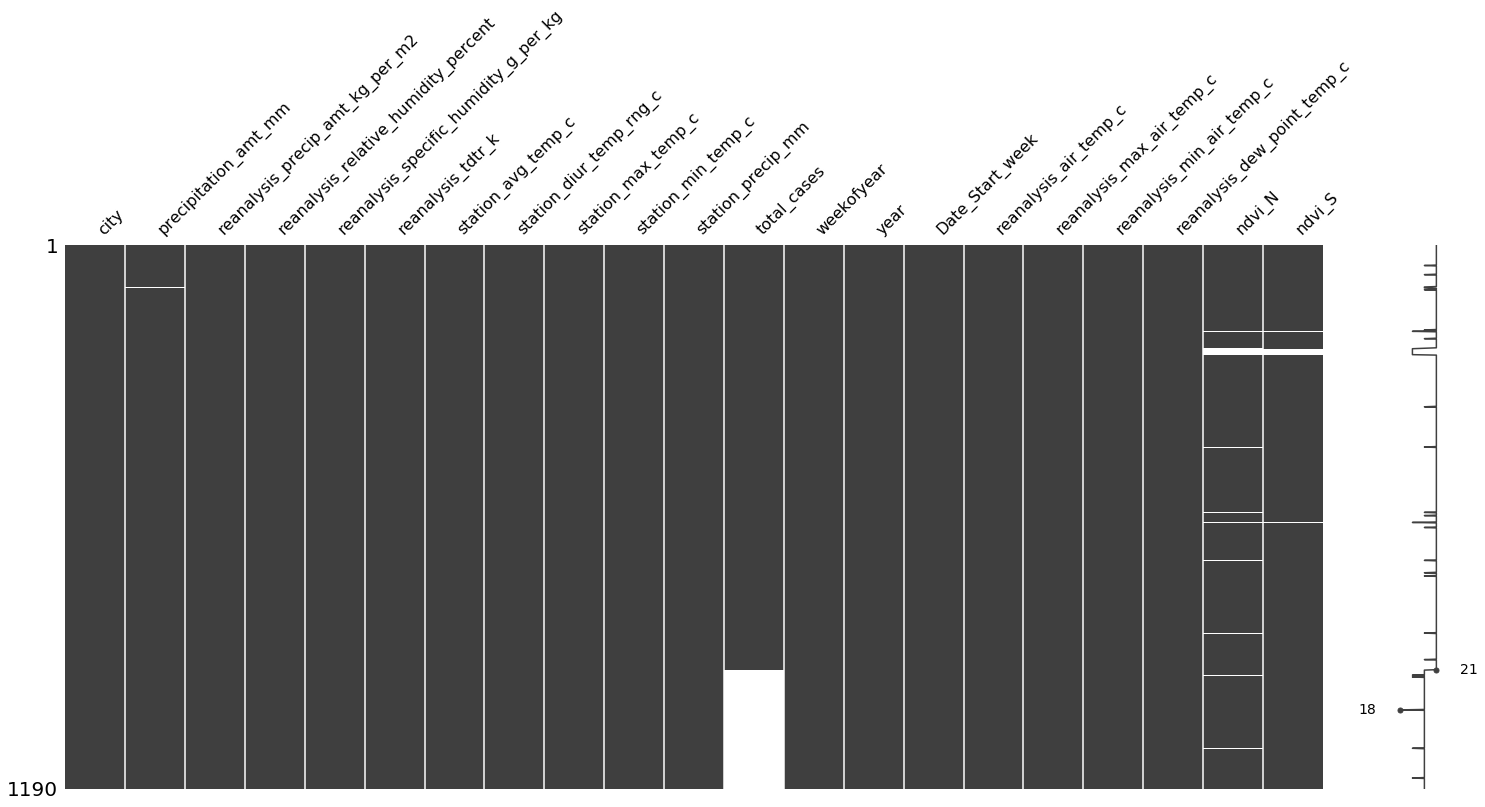

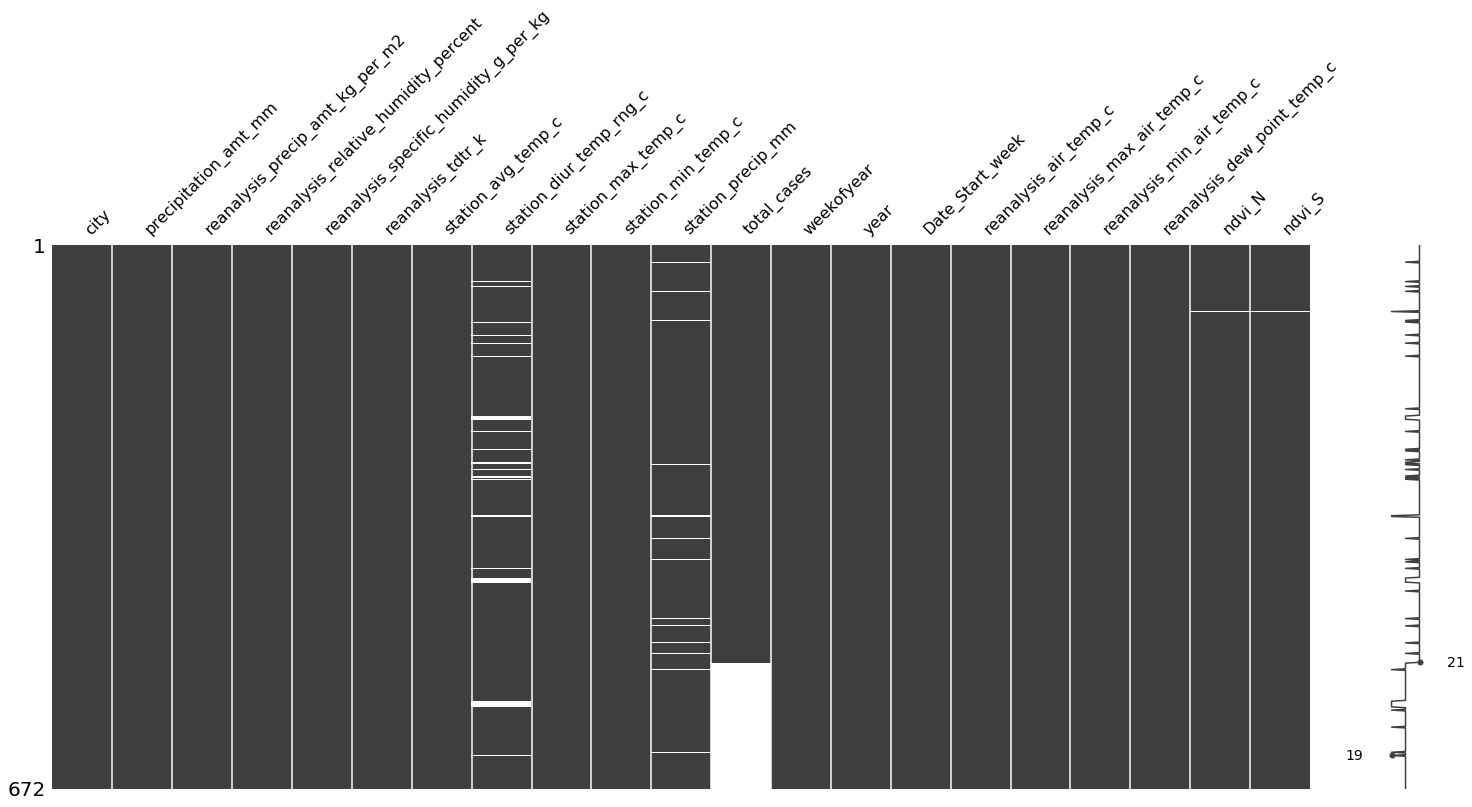

In [19]:
msno.matrix(df_TOTAL[df_TOTAL['city']=='sj'])
plt.show()

msno.matrix(df_TOTAL[df_TOTAL['city']=='iq'])
plt.show()

Ara ens queden Nans a iq en dues variables (encara no hem mirat el ndvi): la variacio diurna de temperatura i la precipitation
    1. jo faria: primer la preciptacio, la comparem amb les altres dues i veiem si les podem fer servir per omplir els valors
    2. despres faria un KNN per la variacio tenint en compte valors mitjans, maxims, minims i pluja.

### Omplim station_precip_mm 
    1- 'iq': posar el valor de precipitation_amt_mm --> el resultat es igual que el metode amb Ridge utilitzant aquest de predictor. (ens quedem amb aixo **facil i senzill**)
    2-  part, per ciutat 'sj', hi han alguns NaNs per precipitation_amt_mm i reanalisis_amt. Mirant les altres dues features de precipitation, veiem que la que te mes relacio es la reanalysis_precip_amt_kg_per_m2. La farem servir per imputar NaNs

In [20]:
# precipi per iq amb valor_amt_mm
id_missing= df_TOTAL[pd.isnull(df_TOTAL['station_precip_mm'])].index.tolist()
df_TOTAL['station_precip_mm'][id_missing]= df_TOTAL.loc[id_missing]['precipitation_amt_mm'].values


# precip_amt (sj) amb dades prcip reanalysis
id_missing= df_TOTAL[pd.isnull(df_TOTAL['precipitation_amt_mm'])].index.tolist()
df_TOTAL['precipitation_amt_mm'][id_missing]= df_TOTAL.loc[id_missing]['reanalysis_precip_amt_kg_per_m2'].values

# Per seguir fent coses ara tornem a separar entre localitzacions

In [21]:
df_iq = df_TOTAL[df_TOTAL['city']=='iq'] # aixo te train i test eh
df_sj = df_TOTAL[df_TOTAL['city']=='sj'] # aixo te train i test eh

#### ara per 'iq' nomes ens queda completar la variacio diurna de temperatura
mirem correlacions lineals.
* podem fre-ho complicat i aplicar model de regressio amb variables amb mes 0.5 de correlacio (per exemple) --> Ridgle
* podem fer una correlacio lineal tal qual (lineal regression nomes amb la station_max_temp_rng_c) --> 0.66 de correlacio

Fent LR nomes amb una variable dona un error de 0.9. Fent **Ridge** amb mes d'una tenim error absolut de 0.8. Fem aquest.

In [22]:
# omplim iq
features_train_num_test = ['station_diur_temp_rng_c','station_max_temp_c','reanalysis_max_air_temp_c','reanalysis_relative_humidity_percent','reanalysis_tdtr_k']
features_train_num_test_X =  ['station_max_temp_c','reanalysis_max_air_temp_c','reanalysis_relative_humidity_percent','reanalysis_tdtr_k']
train_rain0=df_iq.loc[:,features_train_num_test]

id_missing= train_rain0[pd.isnull(train_rain0['station_diur_temp_rng_c'])].index.tolist()

xx = train_rain0[features_train_num_test_X].drop(id_missing,axis=0).values

yy=train_rain0['station_diur_temp_rng_c'].drop(id_missing,axis=0).values.reshape(-1,1)

xx_test=train_rain0.loc[id_missing][features_train_num_test_X].values

from sklearn.linear_model import Ridge

Rlin= Ridge()

results = cross_val_score(Rlin, xx, yy, cv=6, scoring='neg_mean_absolute_error')
print('Mean absolute error Ridge:',(-results.mean()))

#predict
Rlin.fit(xx,yy)
pred=Rlin.predict(xx_test)


# ho posem on toca i fem un plot de la time series per veure com queda
df_iq['station_diur_temp_rng_c'][id_missing] = pred[:,0]

Mean absolute error Ridge: 0.7912942497060079


### Repassem NaNs

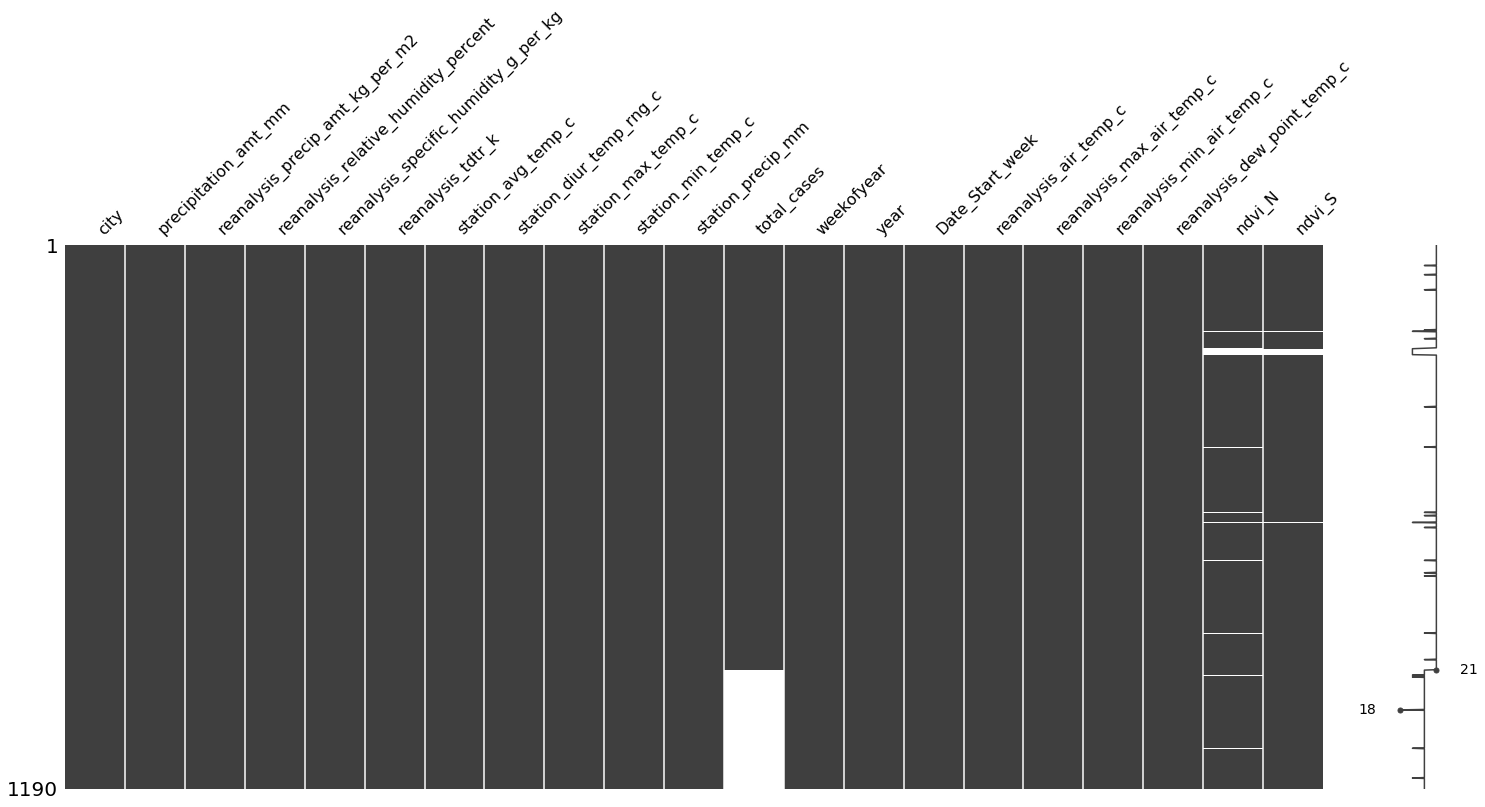

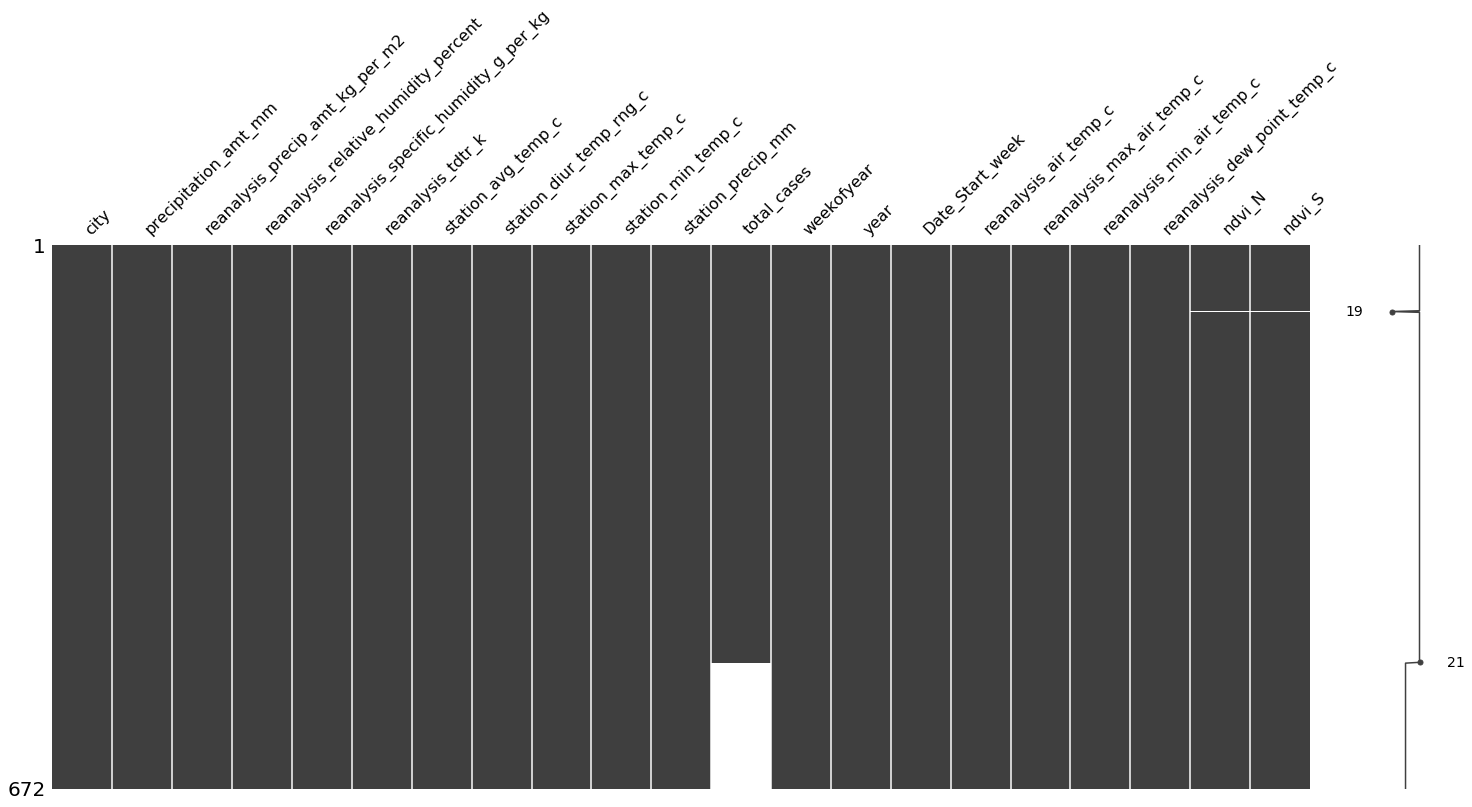

In [23]:
msno.matrix(df_sj)
plt.show()

msno.matrix(df_iq)
plt.show()

# provem interpolacio amb funcio time.
    1- per fer-ho hem de posar time al index primer
    2- aixo tb ho podriem haver fet amb totes le svariables previes..... (ho provarem en un altre)


In [24]:
df_iq = df_iq.reset_index().set_index('Date_Start_week')
df_sj = df_sj.reset_index().set_index('Date_Start_week')
df_iq.head()

,index,city,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,...,station_precip_mm,total_cases,weekofyear,year,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_dew_point_temp_c,ndvi_N,ndvi_S
Date_Start_week,,,,,,,,,,,,,,,,,,,,,
2000-07-01,936,iq,25.41,43.19,92.418571,16.651429,8.928571,26.400000,10.775000,32.5,...,3.0,0.0,26,2000,23.590000,34.15,19.95,22.034286,0.162571,0.294043
2000-07-08,937,iq,60.61,46.00,93.581429,16.862857,10.314286,26.900000,11.566667,34.0,...,55.6,0.0,27,2000,23.484286,33.45,17.95,22.208571,0.246467,0.265557
2000-07-15,938,iq,55.52,64.77,95.848571,17.120000,7.385714,26.800000,11.466667,33.0,...,38.1,0.0,28,2000,23.265714,31.35,19.45,22.472857,0.174943,0.166064
2000-07-22,939,iq,5.60,23.96,87.234286,14.431429,9.114286,25.766667,10.533333,31.5,...,30.0,0.0,29,2000,22.207143,30.45,15.45,19.647143,0.186579,0.227257
2000-07-29,940,iq,62.76,31.80,88.161429,15.444286,9.500000,26.600000,11.480000,33.3,...,4.0,0.0,30,2000,23.282857,33.85,18.35,20.807143,0.325386,0.307707


In [25]:
df_iq['ndvi_N'] = df_iq['ndvi_N'].interpolate(method='time')
df_sj['ndvi_N'] = df_sj['ndvi_N'].interpolate(method='time')
df_sj['ndvi_S'] = df_sj['ndvi_S'].interpolate(method='time')

### Ara tornem a separar en train i test per cada ciutat

In [26]:
df_iq = df_iq.set_index('index')
df_sj = df_sj.set_index('index')

In [27]:
# SJ
# per tornar a train i test, fem servir els labels (NaNs son test)
id_missing= df_sj[pd.isnull(df_sj['total_cases'])].index.tolist()

df_sj_train = df_sj.drop(id_missing,axis=0)
df_sj_train = df_sj_train.drop(columns=['total_cases','city','year'])

df_sj_test = df_sj.loc[id_missing]
df_sj_test = df_sj_test.drop(columns=['total_cases','city','year'])

df_sj_labels = train_labels_df[train_labels_df['city']=='sj']


# IQ
# per tornar a train i test, fem servir els labels (NaNs son test)
id_missing= df_iq[pd.isnull(df_iq['total_cases'])].index.tolist()

df_iq_train = df_iq.drop(id_missing,axis=0)
df_iq_train = df_iq_train.drop(columns=['total_cases','city','year'])

df_iq_test = df_iq.loc[id_missing]
df_iq_test = df_iq_test.drop(columns=['total_cases','city','year'])

df_iq_labels = train_labels_df[train_labels_df['city']=='iq']

In [28]:
df_sj_train.head()

,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_dew_point_temp_c,ndvi_N,ndvi_S
index,,,,,,,,,,,,,,,,,
0,12.42,32.00,73.365714,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,18,24.422857,26.65,22.75,19.264286,0.113162,0.188050
1,22.82,17.94,77.368571,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,19,25.061429,27.75,23.25,20.801429,0.156037,0.158921
2,34.54,26.10,82.052857,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,20,25.631429,27.35,24.15,22.284286,0.102608,0.164021
3,15.36,13.90,80.337143,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,21,25.837143,28.25,23.85,22.160000,0.186850,0.231721
4,7.52,12.20,80.460000,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,22,26.368571,28.75,24.35,22.671429,0.229200,0.249270


In [29]:
df_sj_train.shape

(930, 17)

In [30]:
df_sj_labels

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
5,sj,1990,23,2
6,sj,1990,24,4
7,sj,1990,25,5
8,sj,1990,26,10
9,sj,1990,27,6


# MODELS
## Apliquem un gradient XGBoost per veure importancia features

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import plot_importance

In [32]:
model = XGBRegressor()
kfold = KFold(n_splits=10)

In [33]:
## iq

Mean Absolute error IQ: -7.556162377101893


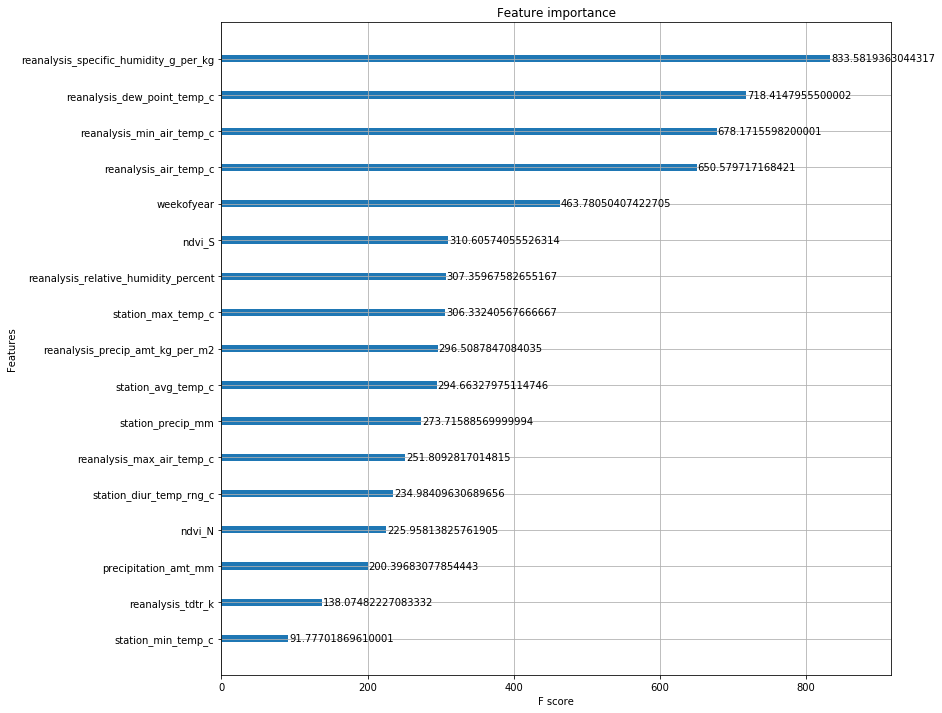

In [34]:
Xx_train=df_iq_train
yy_train=df_iq_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error IQ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

Mean Absolute error SJ: -26.874435102298698


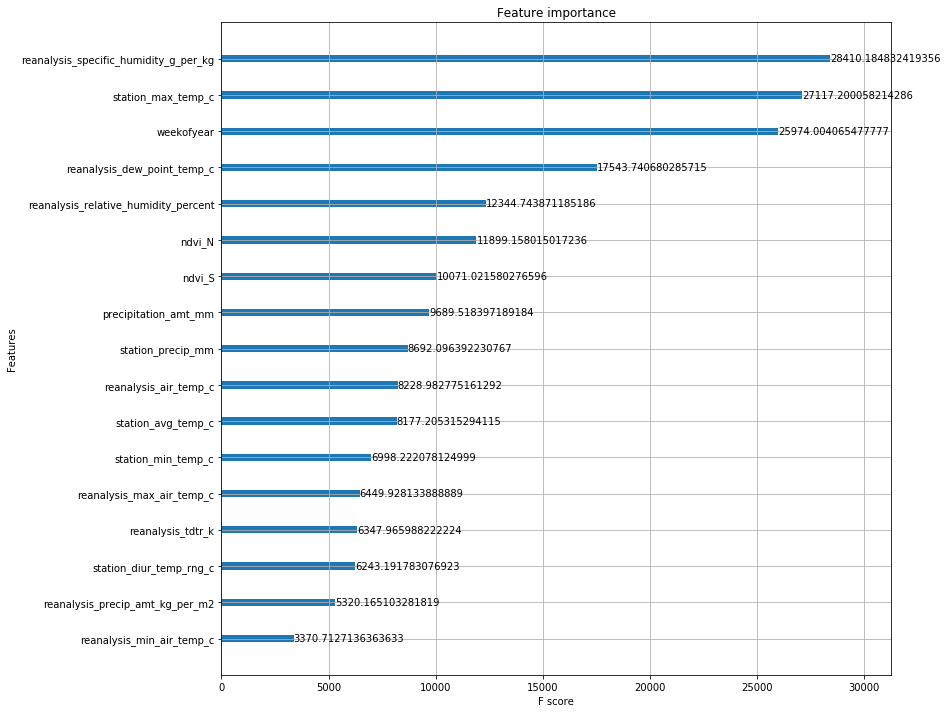

In [35]:
Xx_train=df_sj_train
yy_train=df_sj_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SJ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

## Veiem que per cada un les features son diferents
1. ara el que farem es crear features que tinguin en compte evolucio variables --> ho farem fem mitjanes variables previes

### SJ

In [36]:
# station_max_temp_c
df_sj_train['R2_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(2).mean()
df_sj_train['R3_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(3).mean()
df_sj_train['R4_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(4).mean()
df_sj_train['R5_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(5).mean()
df_sj_train['R6_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(6).mean()
df_sj_train['R7_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(7).mean()
df_sj_train['R8_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(8).mean() # 8 setmanes!
df_sj_train['R9_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(9).mean() # 8 setmanes!
df_sj_train['R10_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(10).mean() # 8 setmanes!
df_sj_train['R11_station_max_temp_c'] = df_sj_train['station_max_temp_c'].rolling(11).mean() # 8 setmanes!


# reanalysis_specific_humidity_g_per_kg
df_sj_train['R2_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(2).mean()
df_sj_train['R3_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(3).mean()
df_sj_train['R4_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(4).mean()
df_sj_train['R5_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(5).mean()
df_sj_train['R6_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(6).mean()
df_sj_train['R7_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(7).mean()
df_sj_train['R8_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(8).mean()
df_sj_train['R9_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(9).mean()
df_sj_train['R10_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(10).mean()
df_sj_train['R11_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['reanalysis_specific_humidity_g_per_kg'].rolling(11).mean()


# precipitation_amt_mm
df_sj_train['R2_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(2).mean()
df_sj_train['R3_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(3).mean()
df_sj_train['R4_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(4).mean()
df_sj_train['R5_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(5).mean()
df_sj_train['R6_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(6).mean()
df_sj_train['R7_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(7).mean()
df_sj_train['R8_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(8).mean()
df_sj_train['R9_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(9).mean()
df_sj_train['R10_precipitation_amt_mm'] = df_sj_train['precipitation_amt_mm'].rolling(10).mean()


# reanalysis_dew_point_temp_c
df_sj_train['R2_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(2).mean()
df_sj_train['R3_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(3).mean()
df_sj_train['R4_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(4).mean()
df_sj_train['R5_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(5).mean()
df_sj_train['R6_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(6).mean()
df_sj_train['R7_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(7).mean()
df_sj_train['R8_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(8).mean()
df_sj_train['R9_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(9).mean()
df_sj_train['R10_reanalysis_dew_point_temp_c'] = df_sj_train['reanalysis_dew_point_temp_c'].rolling(10).mean()

# ndvi_N
df_sj_train['R2_ndvi_N'] = df_sj_train['ndvi_N'].rolling(2).mean()
df_sj_train['R3_ndvi_N'] = df_sj_train['ndvi_N'].rolling(3).mean()
df_sj_train['R4_ndvi_N'] = df_sj_train['ndvi_N'].rolling(4).mean()
df_sj_train['R5_ndvi_N'] = df_sj_train['ndvi_N'].rolling(5).mean()
df_sj_train['R6_ndvi_N'] = df_sj_train['ndvi_N'].rolling(6).mean()
df_sj_train['R7_ndvi_N'] = df_sj_train['ndvi_N'].rolling(7).mean()
df_sj_train['R8_ndvi_N'] = df_sj_train['ndvi_N'].rolling(8).mean()
df_sj_train['R9_ndvi_N'] = df_sj_train['ndvi_N'].rolling(9).mean()
df_sj_train['R10_ndvi_N'] = df_sj_train['ndvi_N'].rolling(10).mean()

# ndvi_N
df_sj_train['R2_ndvi_S'] = df_sj_train['ndvi_S'].rolling(2).mean()
df_sj_train['R3_ndvi_S'] = df_sj_train['ndvi_S'].rolling(3).mean()
df_sj_train['R4_ndvi_S'] = df_sj_train['ndvi_S'].rolling(4).mean()
df_sj_train['R5_ndvi_S'] = df_sj_train['ndvi_S'].rolling(5).mean()
df_sj_train['R6_ndvi_S'] = df_sj_train['ndvi_S'].rolling(6).mean()
df_sj_train['R7_ndvi_S'] = df_sj_train['ndvi_S'].rolling(7).mean()
df_sj_train['R8_ndvi_S'] = df_sj_train['ndvi_S'].rolling(8).mean()
df_sj_train['R9_ndvi_S'] = df_sj_train['ndvi_S'].rolling(9).mean()
df_sj_train['R10_ndvi_S'] = df_sj_train['ndvi_S'].rolling(10).mean()


# -----------------------------------------------------------------

## Ara omplim dades generades

#omplim nans station_max_temp_c
df_sj_train['R2_station_max_temp_c'] = df_sj_train['R2_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R3_station_max_temp_c'] = df_sj_train['R3_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R4_station_max_temp_c'] = df_sj_train['R4_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R5_station_max_temp_c'] = df_sj_train['R5_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R6_station_max_temp_c'] = df_sj_train['R6_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R7_station_max_temp_c'] = df_sj_train['R7_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R8_station_max_temp_c'] = df_sj_train['R8_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R9_station_max_temp_c'] = df_sj_train['R9_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R10_station_max_temp_c'] = df_sj_train['R10_station_max_temp_c'].fillna(method='backfill')
df_sj_train['R11_station_max_temp_c'] = df_sj_train['R11_station_max_temp_c'].fillna(method='backfill')


# reanalysis_specific_humidity_g_per_kg
df_sj_train['R2_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R2_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R3_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R3_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R4_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R4_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R5_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R5_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R6_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R6_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R7_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R7_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R8_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R8_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R9_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R9_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R10_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R10_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_train['R11_reanalysis_specific_humidity_g_per_kg'] = df_sj_train['R11_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')


# precipitation_amt_mm
df_sj_train['R2_precipitation_amt_mm'] = df_sj_train['R2_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R3_precipitation_amt_mm'] = df_sj_train['R3_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R4_precipitation_amt_mm'] = df_sj_train['R4_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R5_precipitation_amt_mm'] = df_sj_train['R5_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R6_precipitation_amt_mm'] = df_sj_train['R6_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R7_precipitation_amt_mm'] = df_sj_train['R7_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R8_precipitation_amt_mm'] = df_sj_train['R8_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R9_precipitation_amt_mm'] = df_sj_train['R9_precipitation_amt_mm'].fillna(method='backfill')
df_sj_train['R10_precipitation_amt_mm'] = df_sj_train['R10_precipitation_amt_mm'].fillna(method='backfill')

# R2_reanalysis_dew_point_temp_c
df_sj_train['R2_reanalysis_dew_point_temp_c'] = df_sj_train['R2_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R3_reanalysis_dew_point_temp_c'] = df_sj_train['R3_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R4_reanalysis_dew_point_temp_c'] = df_sj_train['R4_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R5_reanalysis_dew_point_temp_c'] = df_sj_train['R5_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R6_reanalysis_dew_point_temp_c'] = df_sj_train['R6_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R7_reanalysis_dew_point_temp_c'] = df_sj_train['R7_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R8_reanalysis_dew_point_temp_c'] = df_sj_train['R8_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R9_reanalysis_dew_point_temp_c'] = df_sj_train['R9_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_sj_train['R10_reanalysis_dew_point_temp_c'] = df_sj_train['R10_reanalysis_dew_point_temp_c'].fillna(method='backfill')


# ndvi_N
df_sj_train['R2_ndvi_N'] = df_sj_train['R2_ndvi_N'].fillna(method='backfill')
df_sj_train['R3_ndvi_N'] = df_sj_train['R3_ndvi_N'].fillna(method='backfill')
df_sj_train['R4_ndvi_N'] = df_sj_train['R4_ndvi_N'].fillna(method='backfill')
df_sj_train['R5_ndvi_N'] = df_sj_train['R5_ndvi_N'].fillna(method='backfill')
df_sj_train['R6_ndvi_N'] = df_sj_train['R6_ndvi_N'].fillna(method='backfill')
df_sj_train['R7_ndvi_N'] = df_sj_train['R7_ndvi_N'].fillna(method='backfill')
df_sj_train['R8_ndvi_N'] = df_sj_train['R8_ndvi_N'].fillna(method='backfill')
df_sj_train['R9_ndvi_N'] = df_sj_train['R9_ndvi_N'].fillna(method='backfill')
df_sj_train['R10_ndvi_N'] = df_sj_train['R10_ndvi_N'].fillna(method='backfill')

# ndvi_N
df_sj_train['R2_ndvi_S'] = df_sj_train['R2_ndvi_S'].fillna(method='backfill')
df_sj_train['R3_ndvi_S'] = df_sj_train['R3_ndvi_S'].fillna(method='backfill')
df_sj_train['R4_ndvi_S'] = df_sj_train['R4_ndvi_S'].fillna(method='backfill')
df_sj_train['R5_ndvi_S'] = df_sj_train['R5_ndvi_S'].fillna(method='backfill')
df_sj_train['R6_ndvi_S'] = df_sj_train['R6_ndvi_S'].fillna(method='backfill')
df_sj_train['R7_ndvi_S'] = df_sj_train['R7_ndvi_S'].fillna(method='backfill')
df_sj_train['R8_ndvi_S'] = df_sj_train['R8_ndvi_S'].fillna(method='backfill')
df_sj_train['R9_ndvi_S'] = df_sj_train['R9_ndvi_S'].fillna(method='backfill')
df_sj_train['R10_ndvi_S'] = df_sj_train['R10_ndvi_S'].fillna(method='backfill')

Mean Absolute error SJ: -26.033200309289395


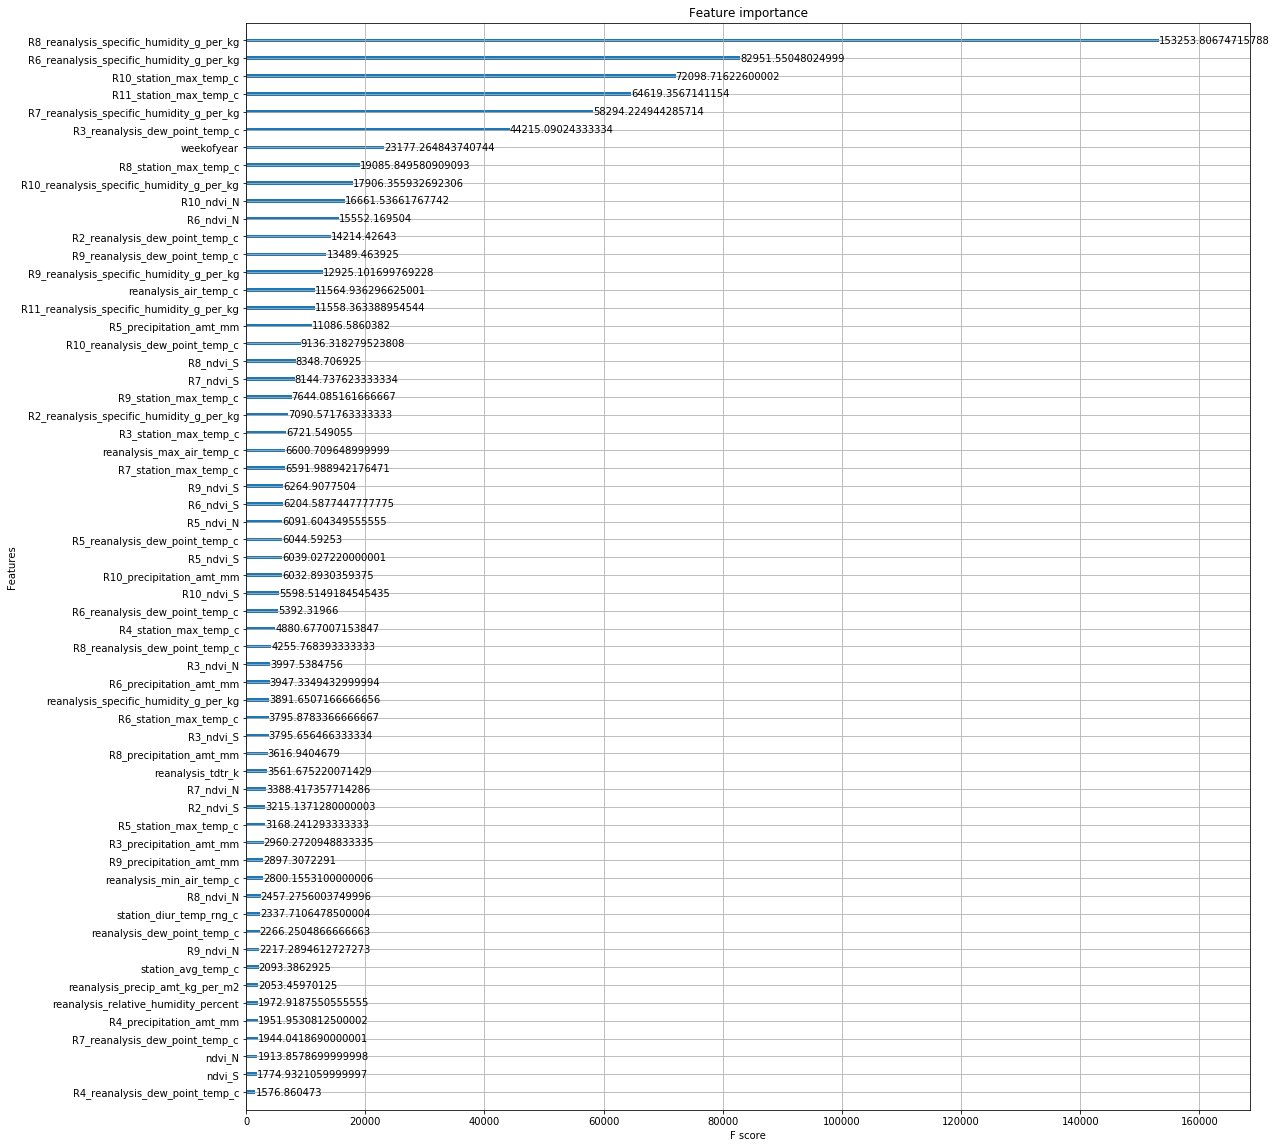

In [37]:
Xx_train=df_sj_train
yy_train=df_sj_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SJ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

In [38]:
df_sj_train.columns

Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c', 'ndvi_N',
       'ndvi_S', 'R2_station_max_temp_c', 'R3_station_max_temp_c',
       'R4_station_max_temp_c', 'R5_station_max_temp_c',
       'R6_station_max_temp_c', 'R7_station_max_temp_c',
       'R8_station_max_temp_c', 'R9_station_max_temp_c',
       'R10_station_max_temp_c', 'R11_station_max_temp_c',
       'R2_reanalysis_specific_humidity_g_per_kg',
       'R3_reanalysis_specific_humidity_g_per_kg',
       'R4_reanalysis_specific_humidity_g_per_kg',
       'R5_reanalysis_specific_humidity_g_per_kg',
       'R6_reanalysis_specific_humidi

In [39]:
list_features_sj=['weekofyear','R8_reanalysis_specific_humidity_g_per_kg','R6_reanalysis_specific_humidity_g_per_kg',
               'R10_station_max_temp_c','R11_station_max_temp_c','R7_reanalysis_specific_humidity_g_per_kg']


Xx_train=df_sj_train[list_features_sj]
yy_train=df_sj_labels['total_cases'].values

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))

Mean Absolute error SJ: -24.668871611933554


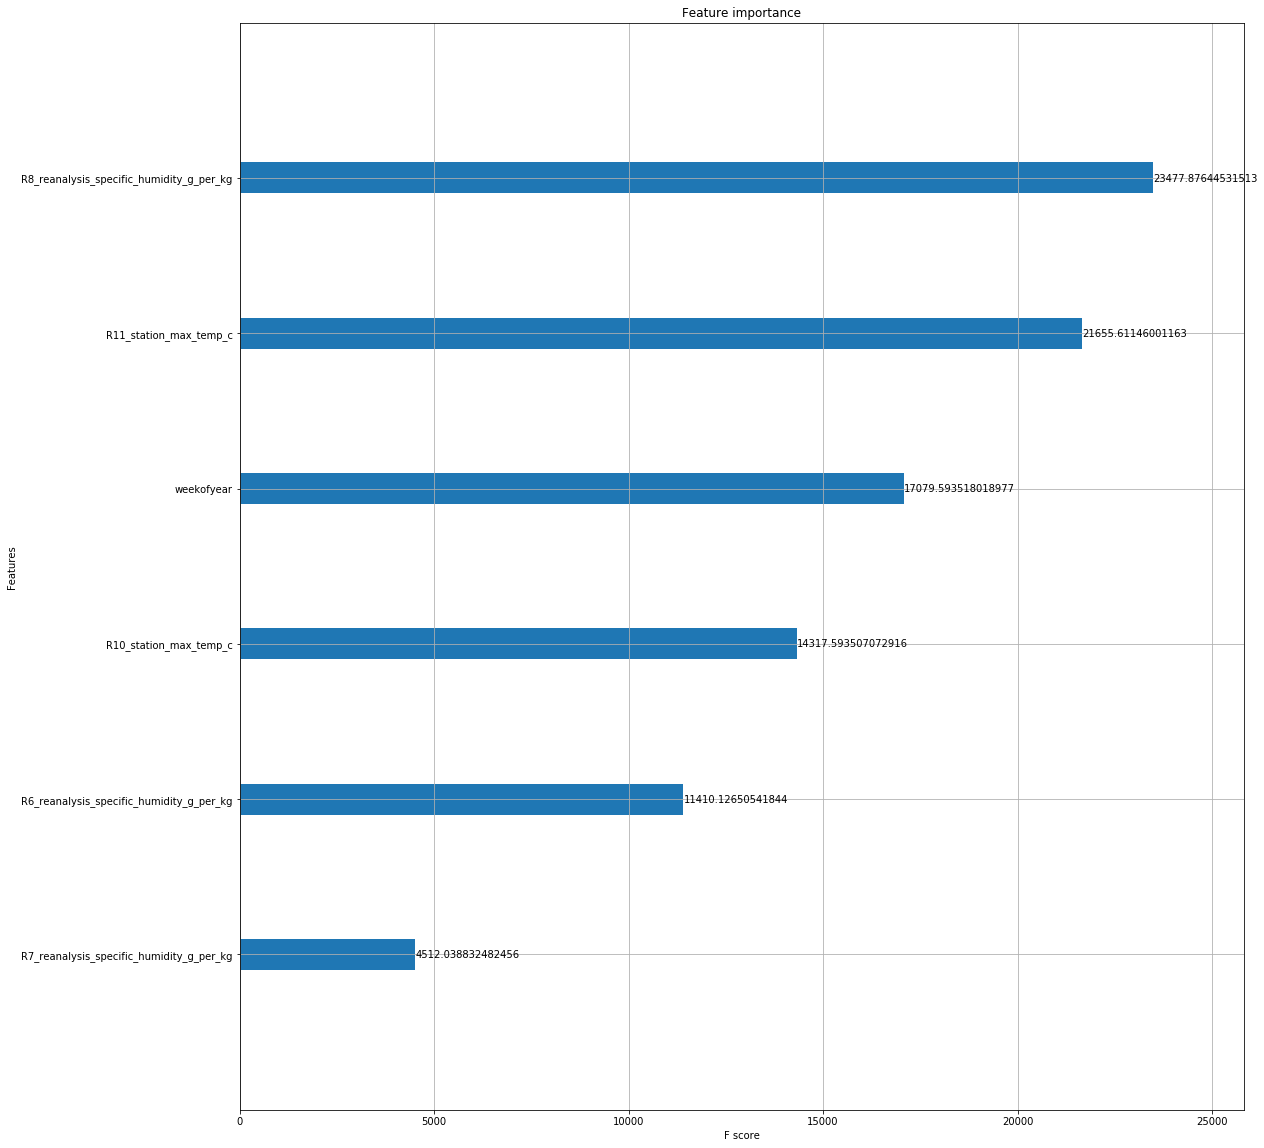

In [40]:
results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SJ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

### IQ

In [41]:
df_iq_train.columns

Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c', 'ndvi_N',
       'ndvi_S'],
      dtype='object')

In [42]:
# reanalysis_specific_humidity_g_per_kg
df_iq_train['R2_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(2).mean()
df_iq_train['R3_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(3).mean()
df_iq_train['R4_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(4).mean()
df_iq_train['R5_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(5).mean()
df_iq_train['R6_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(6).mean()
df_iq_train['R7_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(7).mean()
df_iq_train['R8_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(8).mean()
df_iq_train['R9_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(9).mean()
df_iq_train['R10_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(10).mean()
df_iq_train['R11_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['reanalysis_specific_humidity_g_per_kg'].rolling(11).mean()

# reanalysis_dew_point_temp_c
df_iq_train['R2_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(2).mean()
df_iq_train['R3_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(3).mean()
df_iq_train['R4_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(4).mean()
df_iq_train['R5_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(5).mean()
df_iq_train['R6_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(6).mean()
df_iq_train['R7_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(7).mean()
df_iq_train['R8_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(8).mean()
df_iq_train['R9_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(9).mean()
df_iq_train['R10_reanalysis_dew_point_temp_c'] = df_iq_train['reanalysis_dew_point_temp_c'].rolling(10).mean()

# reanalysis_min_air_temp_c
df_iq_train['R2_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(2).mean()
df_iq_train['R3_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(3).mean()
df_iq_train['R4_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(4).mean()
df_iq_train['R5_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(5).mean()
df_iq_train['R6_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(6).mean()
df_iq_train['R7_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(7).mean()
df_iq_train['R8_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(8).mean()
df_iq_train['R9_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(9).mean()
df_iq_train['R10_reanalysis_min_air_temp_c'] = df_iq_train['reanalysis_min_air_temp_c'].rolling(10).mean()

# reanalysis_air_temp_c
df_iq_train['R2_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(2).mean()
df_iq_train['R3_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(3).mean()
df_iq_train['R4_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(4).mean()
df_iq_train['R5_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(5).mean()
df_iq_train['R6_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(6).mean()
df_iq_train['R7_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(7).mean()
df_iq_train['R8_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(8).mean()
df_iq_train['R9_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(9).mean()
df_iq_train['R10_reanalysis_air_temp_c'] = df_iq_train['reanalysis_air_temp_c'].rolling(10).mean()


#-------------------
# reanalysis_specific_humidity_g_per_kg
df_iq_train['R2_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R2_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R3_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R3_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R4_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R4_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R5_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R5_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R6_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R6_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R7_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R7_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R8_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R8_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R9_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R9_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R10_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R10_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_iq_train['R11_reanalysis_specific_humidity_g_per_kg'] = df_iq_train['R11_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')

# reanalysis_dew_point_temp_c
df_iq_train['R2_reanalysis_dew_point_temp_c'] = df_iq_train['R2_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R3_reanalysis_dew_point_temp_c'] = df_iq_train['R3_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R4_reanalysis_dew_point_temp_c'] = df_iq_train['R4_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R5_reanalysis_dew_point_temp_c'] = df_iq_train['R5_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R6_reanalysis_dew_point_temp_c'] = df_iq_train['R6_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R7_reanalysis_dew_point_temp_c'] = df_iq_train['R7_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R8_reanalysis_dew_point_temp_c'] = df_iq_train['R8_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R9_reanalysis_dew_point_temp_c'] = df_iq_train['R9_reanalysis_dew_point_temp_c'].fillna(method='backfill')
df_iq_train['R10_reanalysis_dew_point_temp_c'] = df_iq_train['R10_reanalysis_dew_point_temp_c'].fillna(method='backfill')

# reanalysis_min_air_temp_c
df_iq_train['R2_reanalysis_min_air_temp_c'] = df_iq_train['R2_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R3_reanalysis_min_air_temp_c'] = df_iq_train['R3_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R4_reanalysis_min_air_temp_c'] = df_iq_train['R4_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R5_reanalysis_min_air_temp_c'] = df_iq_train['R5_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R6_reanalysis_min_air_temp_c'] = df_iq_train['R6_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R7_reanalysis_min_air_temp_c'] = df_iq_train['R7_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R8_reanalysis_min_air_temp_c'] = df_iq_train['R8_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R9_reanalysis_min_air_temp_c'] = df_iq_train['R9_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_train['R10_reanalysis_min_air_temp_c'] = df_iq_train['R10_reanalysis_min_air_temp_c'].fillna(method='backfill')

# reanalysis_air_temp_c
df_iq_train['R2_reanalysis_air_temp_c'] = df_iq_train['R2_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R3_reanalysis_air_temp_c'] = df_iq_train['R3_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R4_reanalysis_air_temp_c'] = df_iq_train['R4_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R5_reanalysis_air_temp_c'] = df_iq_train['R5_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R6_reanalysis_air_temp_c'] = df_iq_train['R6_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R7_reanalysis_air_temp_c'] = df_iq_train['R7_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R8_reanalysis_air_temp_c'] = df_iq_train['R8_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R9_reanalysis_air_temp_c'] = df_iq_train['R9_reanalysis_air_temp_c'].fillna(method='backfill')
df_iq_train['R10_reanalysis_air_temp_c'] = df_iq_train['R10_reanalysis_air_temp_c'].fillna(method='backfill')

Mean Absolute error IQ: -7.365673781244778


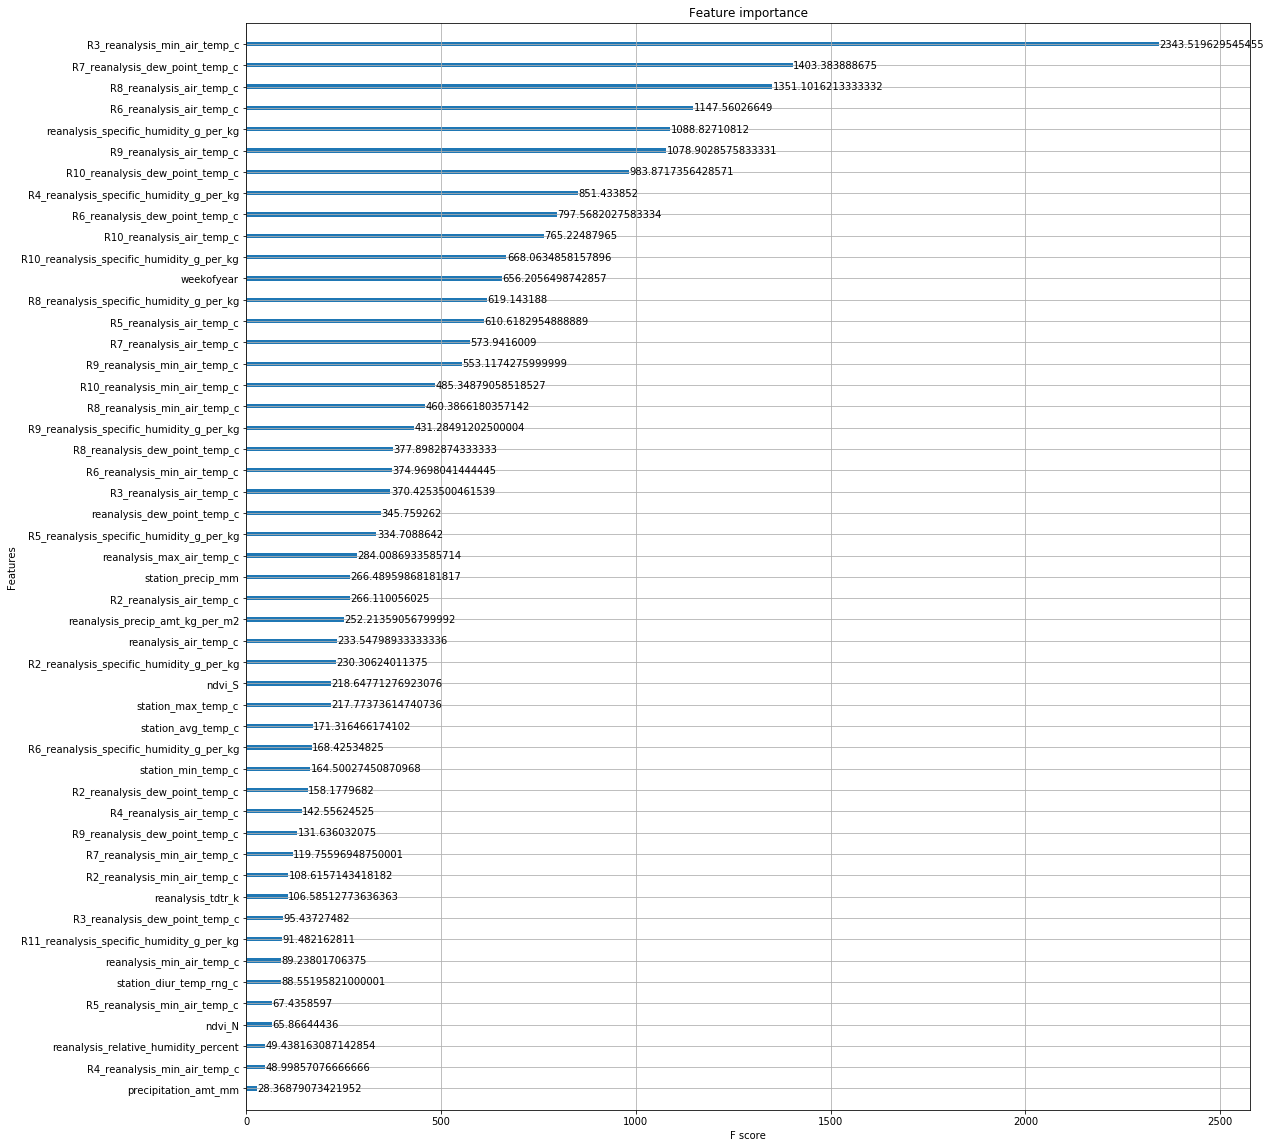

In [43]:
Xx_train=df_iq_train
yy_train=df_iq_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error IQ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

In [44]:
df_iq_train.columns

Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c', 'ndvi_N',
       'ndvi_S', 'R2_reanalysis_specific_humidity_g_per_kg',
       'R3_reanalysis_specific_humidity_g_per_kg',
       'R4_reanalysis_specific_humidity_g_per_kg',
       'R5_reanalysis_specific_humidity_g_per_kg',
       'R6_reanalysis_specific_humidity_g_per_kg',
       'R7_reanalysis_specific_humidity_g_per_kg',
       'R8_reanalysis_specific_humidity_g_per_kg',
       'R9_reanalysis_specific_humidity_g_per_kg',
       'R10_reanalysis_specific_humidity_g_per_kg',
       'R11_reanalysis_specific_humidity_g_per_kg',
       'R2_reana

In [45]:
list_features_iq=['R3_reanalysis_min_air_temp_c']


Xx_train=df_iq_train[list_features_iq]
yy_train=df_iq_labels['total_cases'].values

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))

Mean Absolute error IQ: -6.703803940231984


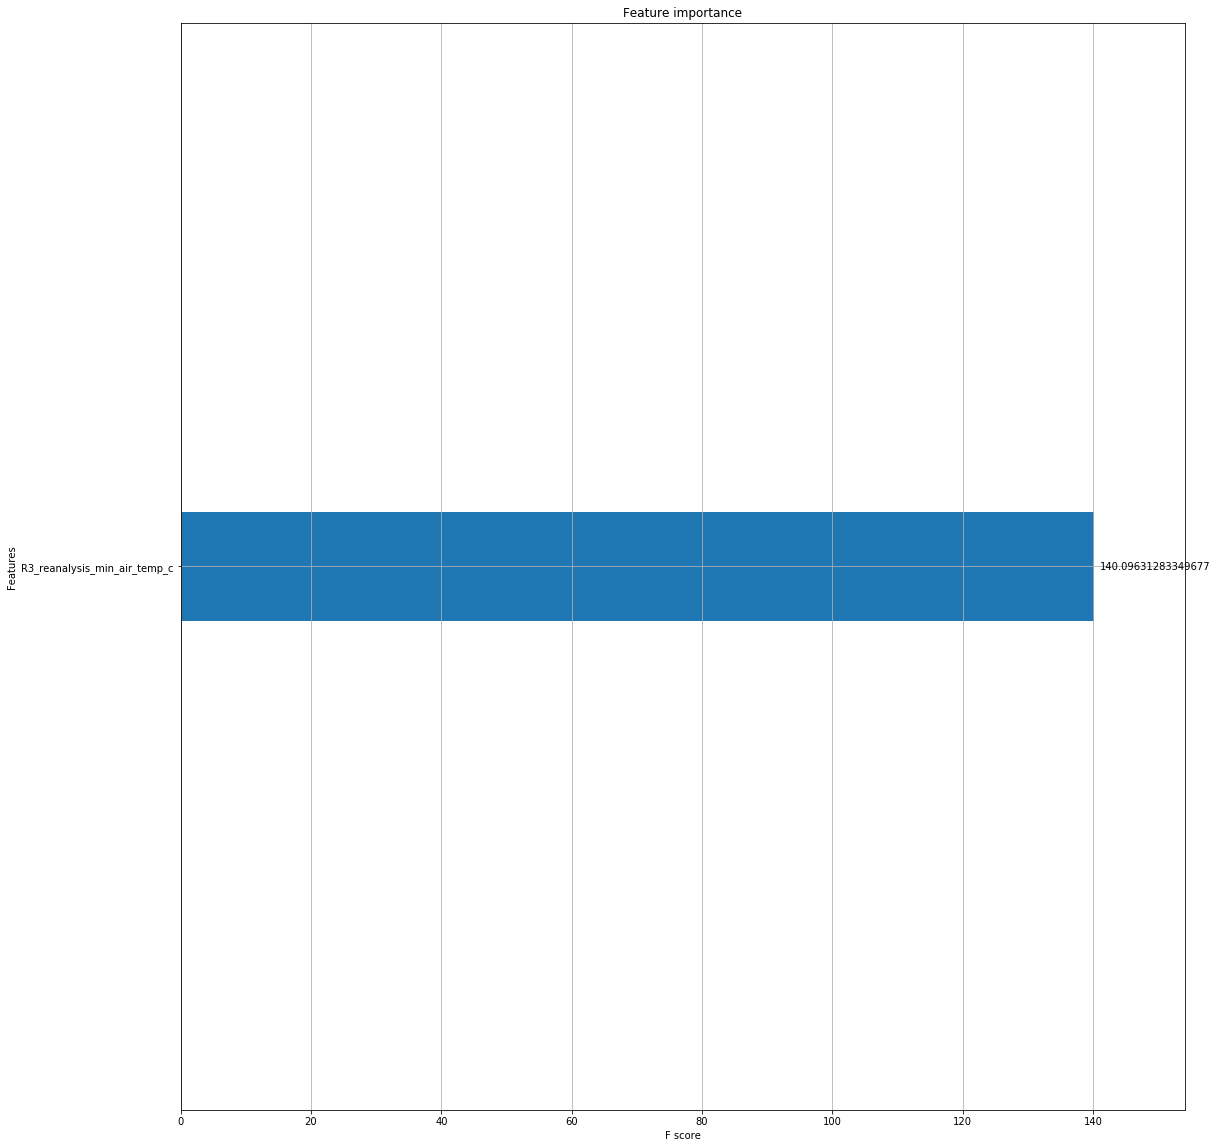

In [46]:
results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error IQ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

## A ) per IQ la millor solucio es amb una variable: 
    *'R3_reanalysis_min_air_temp_c'

## B) per SJ la millor te en compte diferents variables:
    * 

Aixo ho farem servir amb un model nou

In [47]:
from sklearn.svm import SVR

Xx_train=df_iq_train[list_features_iq]
yy_train=df_iq_labels['total_cases'].values

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    

modelSVR_iq = SVR(kernel='rbf', C= 20, coef0= 1, epsilon = .05) #en teoria ja hem fet hyperparametres, mateixosper rbf
results = cross_val_score(modelSVR_iq, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SVR per IQ amb una variable nomes:", (results.mean()))

Mean Absolute error SVR per IQ amb una variable nomes: -5.8569392522260815


In [48]:
Xx_train=df_sj_train[list_features_sj]
yy_train=df_sj_labels['total_cases'].values


from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))

modelSVR_sj = SVR(kernel='rbf', C= 100, coef0= 10, epsilon = .05) #en teoria ja hem fet hyperparametres, mateixosper rbf
results = cross_val_score(modelSVR_sj, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SVR per SJ amb una variable nomes:", (results.mean()))

Mean Absolute error SVR per SJ amb una variable nomes: -22.209669957311213


In [49]:
df_sj_test['R6_reanalysis_specific_humidity_g_per_kg'] = df_sj_test['reanalysis_specific_humidity_g_per_kg'].rolling(6).mean()
df_sj_test['R7_reanalysis_specific_humidity_g_per_kg'] = df_sj_test['reanalysis_specific_humidity_g_per_kg'].rolling(7).mean()
df_sj_test['R8_reanalysis_specific_humidity_g_per_kg'] = df_sj_test['reanalysis_specific_humidity_g_per_kg'].rolling(8).mean()
df_sj_test['R10_station_max_temp_c'] = df_sj_test['station_max_temp_c'].rolling(10).mean() # 8 setmanes!
df_sj_test['R11_station_max_temp_c'] = df_sj_test['station_max_temp_c'].rolling(11).mean() # 8 setmanes!

###
df_sj_test['R6_reanalysis_specific_humidity_g_per_kg'] = df_sj_test['R6_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_test['R7_reanalysis_specific_humidity_g_per_kg'] = df_sj_test['R7_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')
df_sj_test['R8_reanalysis_specific_humidity_g_per_kg'] = df_sj_test['R8_reanalysis_specific_humidity_g_per_kg'].fillna(method='backfill')

df_sj_test['R10_station_max_temp_c'] = df_sj_test['R10_station_max_temp_c'].fillna(method='backfill')
df_sj_test['R11_station_max_temp_c'] = df_sj_test['R11_station_max_temp_c'].fillna(method='backfill')

In [50]:
## Preparem submision

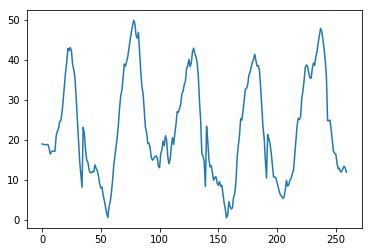

In [51]:
Xx_train=df_sj_train[list_features_sj]
yy_train=df_sj_labels['total_cases'].values


Xx_test=df_sj_test[list_features_sj]

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))
    
modelSVR_sj.fit(Xx_train,yy_train)    
pred_sj = modelSVR_sj.predict(Xx_test)
plt.plot(pred_sj)

In [52]:
df_iq_test['R3_reanalysis_min_air_temp_c'] = df_iq_test['reanalysis_min_air_temp_c'].rolling(3).mean()
df_iq_test['R7_reanalysis_dew_point_temp_c'] = df_iq_test['reanalysis_dew_point_temp_c'].rolling(7).mean()

###
df_iq_test['R3_reanalysis_min_air_temp_c'] = df_iq_test['R3_reanalysis_min_air_temp_c'].fillna(method='backfill')
df_iq_test['R7_reanalysis_dew_point_temp_c'] = df_iq_test['R7_reanalysis_dew_point_temp_c'].fillna(method='backfill')


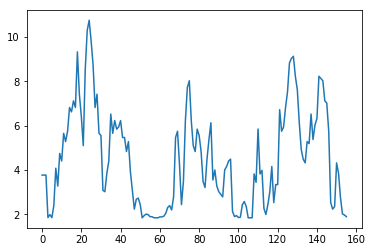

In [53]:
Xx_train=df_iq_train[list_features_iq]
yy_train=df_iq_labels['total_cases'].values

Xx_test=df_iq_test[list_features_iq]

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

modelSVR_iq.fit(Xx_train,yy_train)   
pred_iq = modelSVR_iq.predict(Xx_test)
plt.plot(pred_iq)

In [54]:
pred_sj.astype(int)

array([18, 18, 18, 18, 18, 18, 17, 16, 17, 17, 17, 17, 20, 22, 22, 24, 24,
       26, 29, 33, 36, 39, 42, 42, 43, 42, 38, 37, 35, 30, 25, 19, 14, 11,
        8, 23, 21, 17, 14, 14, 12, 11, 11, 12, 11, 13, 12, 12, 10,  8,  7,
        8,  6,  4,  3,  1,  0,  3,  4,  6,  9, 13, 15, 18, 20, 24, 28, 31,
       32, 35, 38, 38, 39, 40, 43, 45, 47, 48, 49, 49, 46, 45, 46, 42, 37,
       33, 31, 27, 23, 21, 19, 19, 17, 15, 14, 15, 15, 15, 15, 13, 13, 16,
       17, 19, 18, 21, 19, 15, 14, 15, 18, 20, 18, 21, 23, 27, 26, 27, 28,
       31, 32, 33, 34, 37, 38, 40, 38, 39, 41, 42, 41, 40, 39, 35, 29, 24,
       16, 15, 14,  8, 23, 19, 15, 13, 13, 11,  9, 10, 10,  9,  8,  9,  8,
        8,  6,  4,  2,  0,  1,  4,  3,  2,  2,  5,  6,  9, 15, 18, 20, 25,
       24, 27, 29, 32, 32, 33, 36, 36, 38, 39, 40, 41, 39, 38, 38, 37, 33,
       28, 23, 20, 15, 10, 21, 20, 18, 16, 13, 10, 10, 10,  9,  8,  6,  6,
        5,  5,  5,  7,  9,  8,  8,  9, 10, 11, 12, 16, 19, 23, 25, 25, 25,
       30, 32, 34, 38, 38

In [55]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([pred_sj.astype(int), pred_iq.astype(int)])
submission.to_csv("submision4.csv")

In [56]:
## using driven data model for sj

In [58]:
Xx_train=df_sj_train[list_features_sj]
Xx_test=df_sj_test[list_features_sj]

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))


kk11= pd.concat([Xx_train, df_sj_labels['total_cases']], axis=1, sort=False)
sj_train_subtrain = kk11.head(800)
sj_train_subtest = kk11.tail(df_sj_train.shape[0] - 800)

from statsmodels.tools import eval_measures
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "R8_reanalysis_specific_humidity_g_per_kg + " \
                    "R6_reanalysis_specific_humidity_g_per_kg + " \
                    "R10_station_max_temp_c + " \
                    "R11_station_max_temp_c +" \
                    "R7_reanalysis_specific_humidity_g_per_kg"
    
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)


best alpha =  1e-05
best score =  19.99230769230769


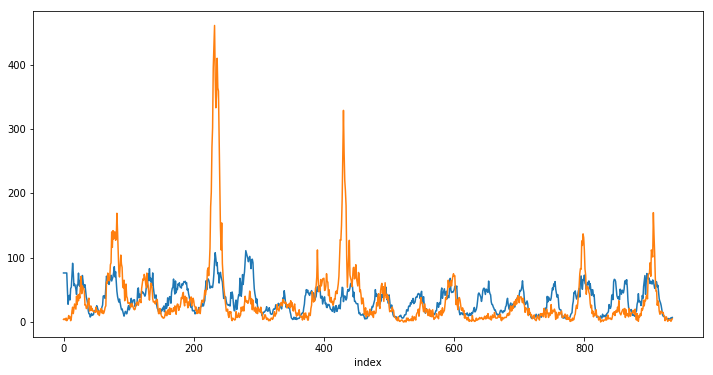

In [59]:
#figs, axes = plt.subplots(nrows=2, ncols=1)

plt.figure(figsize=(12,6))
kk11['fitted'] = sj_best_model.fittedvalues
kk11.fitted.plot(label="Predictions")
kk11.total_cases.plot(label="Actual")
plt.show()

In [60]:
list_features_iq

['R3_reanalysis_min_air_temp_c']

best alpha =  1e-08
best score =  6.655172413793103


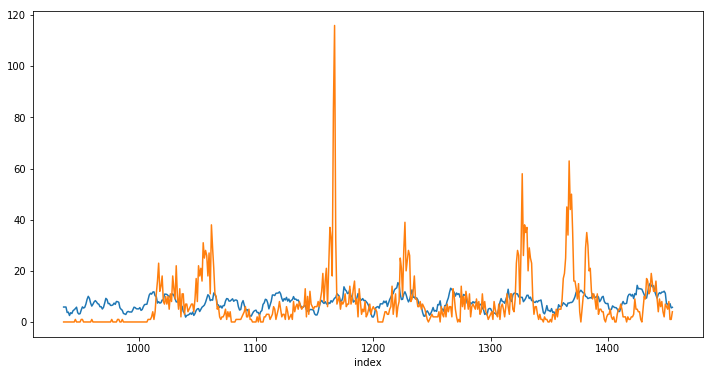

In [61]:
Xx_train=df_iq_train[list_features_iq]
Xx_test=df_iq_test[list_features_iq]

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

kkiq= pd.concat([Xx_train, df_iq_labels['total_cases']], axis=1, sort=False)
iq_train_subtrain = kkiq.head(400)
iq_train_subtest = kkiq.tail(df_iq_train.shape[0] - 400)

from statsmodels.tools import eval_measures
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "R3_reanalysis_min_air_temp_c"
    
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

print (iq_best_model)

plt.figure(figsize=(12,6))
kkiq['fitted'] = iq_best_model.fittedvalues
kkiq.fitted.plot(label="Predictions")
kkiq.total_cases.plot(label="Actual")
plt.show()


In [62]:
model_formula_iq = "total_cases ~ 1 + " \
                    "R3_reanalysis_min_air_temp_c"


Xx_train=df_iq_train[list_features_iq]
Xx_test=df_iq_test[list_features_iq]

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

model_iq = smf.glm(formula=model_formula_iq,
                    data=kkiq,
                    family=sm.families.NegativeBinomial(alpha=1e-08))
results_iq = model_iq.fit()

pred_iq_N = results_iq.predict(Xx_test)



model_formula_sj = "total_cases ~ 1 + " \
                    "R8_reanalysis_specific_humidity_g_per_kg + " \
                    "R6_reanalysis_specific_humidity_g_per_kg + " \
                    "R10_station_max_temp_c + " \
                    "R11_station_max_temp_c +" \
                    "R7_reanalysis_specific_humidity_g_per_kg"

Xx_train=df_sj_train[list_features_sj]
Xx_test=df_sj_test[list_features_sj]

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

model_sj = smf.glm(formula=model_formula_sj,
                    data=kk11,
                    family=sm.families.NegativeBinomial(alpha=1e-05))
results_sj = model_sj.fit()

pred_sj_N = results_sj.predict(Xx_test)

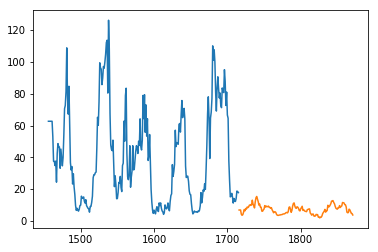

In [63]:
plt.plot(pred_sj_N)
plt.plot(pred_iq_N)

In [64]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([pred_sj_N.astype(int), pred_iq_N.astype(int)])
submission.to_csv("submision5.csv")

In [82]:
df_sj_train.columns

Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c', 'ndvi_N',
       'ndvi_S', 'R2_station_max_temp_c', 'R3_station_max_temp_c',
       'R4_station_max_temp_c', 'R5_station_max_temp_c',
       'R6_station_max_temp_c', 'R7_station_max_temp_c',
       'R8_station_max_temp_c', 'R9_station_max_temp_c',
       'R10_station_max_temp_c', 'R11_station_max_temp_c',
       'R2_reanalysis_specific_humidity_g_per_kg',
       'R3_reanalysis_specific_humidity_g_per_kg',
       'R4_reanalysis_specific_humidity_g_per_kg',
       'R5_reanalysis_specific_humidity_g_per_kg',
       'R6_reanalysis_specific_humidi

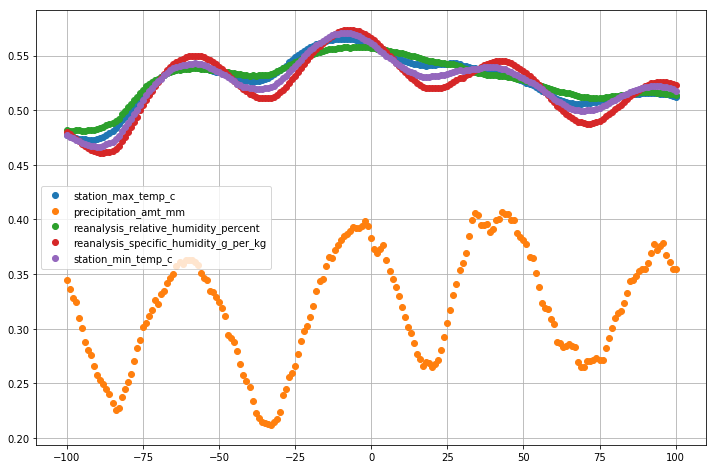

In [94]:
import matplotlib.pyplot as plt
import numpy as np


x=df_sj_train['station_max_temp_c']
x2=df_sj_train['precipitation_amt_mm']
x3=df_sj_train['reanalysis_relative_humidity_percent']
x4=df_sj_train['reanalysis_specific_humidity_g_per_kg']
x5=df_sj_train['station_min_temp_c']

y=df_sj_labels['total_cases'].values

plt.figure(figsize=(12,8))
plt.xcorr(x, y, usevlines=False, maxlags=100, normed=True, lw=2)
plt.xcorr(x2, y, usevlines=False, maxlags=100, normed=True, lw=2)
plt.xcorr(x3, y, usevlines=False, maxlags=100, normed=True, lw=2)
plt.xcorr(x4, y, usevlines=False, maxlags=100, normed=True, lw=2)
plt.xcorr(x5, y, usevlines=False, maxlags=100, normed=True, lw=2)
plt.grid(True)
plt.legend(('station_max_temp_c','precipitation_amt_mm','reanalysis_relative_humidity_percent',
            'reanalysis_specific_humidity_g_per_kg','station_min_temp_c'))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

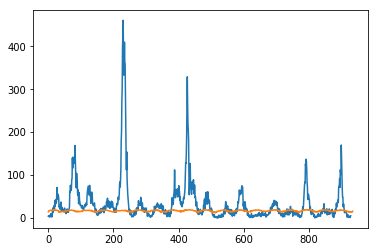

In [78]:
plt.plot(y)
plt.plot(x)